In [1]:
!pip install sentencepiece

In [2]:
!pip install transformers

In [4]:
import h5py

file_path = "/kaggle/input/dataset1/102flowers.hdf5"
with h5py.File(file_path, "r") as file:
    keys = list(file.keys())
for key in keys:
    print(key)

test
train
valid


In [15]:
import os
import io
import h5py
import torch
import ipywidgets
import numpy as np
from torch import nn
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import XLNetTokenizer, XLNetModel
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

In [61]:
training = 1
num_epoch = 25
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = '/kaggle/input/dataset1'
output_path = "/kaggle/input/params"
#encoding texts using xlnet
class Encoder_text(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = XLNetModel.from_pretrained("xlnet-base-cased")
    def forward(self, in_id, token_id, atten_m):
        hidden = self.transformer(
            input_ids=in_id,
            token_types_ids=token_id,
            attention_mask=atten_m
        ).last_hidden_state
        cont = hidden.mean(dim=1)
        cont = cont.view(*cont.shape, 1, 1)
        return cont

In [62]:
#Generator
class Generator(nn.Module):
    def __init__(self, nz=100, nt=768, nc=3, ngf=64):
        super().__init__()
        #layer one
        self.layer1 = nn.Sequential(
            # convolution for input Z
            nn.ConvTranspose2d(nz + nt, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
        )
        #layer two
        self.layer2 = nn.Sequential(
            nn.Conv2d(ngf*8,ngf*2,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
        )
        #layer three
        self.layer3 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*2,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
        )
        #layer four
        self.layer4 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*8,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            
        )
        #layer five
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(ngf * 4),
        )

        #layer six 
        self.layer6 = nn.Sequential(
            nn.Conv2d(ngf*4,ngf,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
        )
        #layer seven
        self.layer7 = nn.Sequential(
            nn.Conv2d(ngf,ngf,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
        )
        #layer eight
        self.layer8 = nn.Sequential(
            nn.Conv2d(ngf,ngf*4,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
        )
        #layer nine
        self.layer9 = nn.Sequential(  
            nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )
        #layer ten
        self.layer10 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        #layer eleven
        self.layer11 = nn.Sequential(
            nn.ConvTranspose2d(ngf,nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )
    #Forward propagation
    def forward(self,noise,encoded_text):
        x = torch.cat([noise,encoded_text],dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        return x

In [63]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, nt=768):
        super().__init__()
        #layer one
        self.layer1 = nn.Sequential(
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        #layer two
        self.layer2 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2,4,2,1,bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        #layer three
        self.layer3 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2,1,bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        #layer four
        self.layer4 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2,1,bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Conv2d(ndf*8,ndf*2,1,1), 
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        #layer five
        self.layer5 = nn.Sequential(
            nn.Conv2d(ndf*2,ndf*2,3,1,1),           
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        #layer six
        self.layer6 = nn.Sequential(
            nn.Conv2d(ndf*2,ndf*8,3,1,1),           
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        #layer conv
        self.concat_image_n_text = nn.Sequential(
            nn.Conv2d(ndf * 8 + nt, ndf * 8, 1, 1, 0, bias=False), ## TODO: Might want to change the kernel size and stride
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf * 8, 2, 4, 1, 0, bias=False),
            nn.Flatten(start_dim=1)
        )
    #forward propagation
    def forward(self, x, encoded_text):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = torch.cat([x, encoded_text.repeat(1, 1, 4, 4)], dim=1)
        x = self.concat_image_n_text(x)
        return x

In [65]:
# preparing data for training class
class Train_prepare:
    def __init__(self, data_path, output_path):
        self.tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
        if os.path.exists(os.path.join(output_path, "d.npy")):
            self.data = np.load(os.path.join(output_path, "d.npy"), allow_pickle=True)
        else:
            f = h5py.File(("/kaggle/input/dataset1/flowers.hdf5"), mode="r")
            self.data = self.Data_prepare(f['train'])
        np.save('d.npy', self.data)
        self.max_seq_len = max(map(lambda x: len(x["text"]["in_id"]), self.data))
        #initializing transformers
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(90, 90)),
            transforms.RandomRotation(degrees=(180, 180)),
            transforms.RandomRotation(degrees=(270, 270)),
            transforms.RandomVerticalFlip(p=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])
    #data preparing method
    def Data_prepare(self, data):
        preparedData = []
        for id, img_name in enumerate(tqdm(data)):
          #due to limited resources such as colab and kaggle we took a portion of data
          if id <=10000:
            image = np.array(Image.open(io.BytesIO(bytes(np.array(data[img_name]['img'])))).resize((256, 256)))
            text = np.array(data[img_name]['txt']).item().strip()
            text = text.decode("utf-8")  # Convert byte string to regular string
            in_id = self.tokenizer.encode(text)
            token_id = [0] * (len(in_id) - 1) + [1]
            atten_m = [1] * len(token_id)
            preparedData.append({
                "image": image,
                "text": {
                    "in_id": in_id,
                    "token_id": token_id,
                    "atten_m": atten_m
                },
            })
        return preparedData

    #padding tokens
    def Tokens_pad(self, text_dict):
        pad_len = self.max_seq_len - sum(text_dict["atten_m"])
        text_dict['in_id'] =  [5] * pad_len + text_dict['in_id'] # <pad> = 5
        text_dict['token_id'] =  [2] * pad_len + text_dict['token_id']
        text_dict['atten_m'] = [0] * pad_len + text_dict['atten_m']   
        return text_dict
    #static method for test
    @staticmethod
    def collate_fn_module(batch, idx):
        images, texts = [], {}
        for data in batch:
            images.append(data[idx][0])
            for key in data[idx][1]:
                if key not in texts:
                    texts[key] = []
                texts[key].append(data[0][1][key])

        images = torch.stack(images).to(device)
        for key in texts:
            texts[key] = torch.tensor(texts[key]).to(device)
        return images, texts

    def collate_fn(self, batch):
        right_images, right_texts = self.collate_fn_module(batch, 0)
        wrong_images, wrong_texts = self.collate_fn_module(batch, 1)
        return (right_images, right_texts), (wrong_images, wrong_texts)
    def __len__(self):
        return len(self.data)
    # need to get item for wrong and right ones to test
    def __getitem__(self, right_id):
        right_data = self.data[right_id].copy()
        right_image = self.transforms(Image.fromarray(right_data["image"]))
        right_text = self.Tokens_pad(right_data["text"].copy())

        wrong_id = np.random.choice([(i) for i in range(len(self.data)) if i != right_id])
        wrong_data = self.data[wrong_id].copy()
        wrong_image = self.transforms(Image.fromarray(wrong_data["image"]))
        wrong_text = self.Tokens_pad(wrong_data["text"].copy())
        return (right_image, right_text), (wrong_image, wrong_text)

In [66]:
%%time
train_dataset = Train_prepare(data_path, output_path)

  0%|          | 0/29390 [00:00<?, ?it/s]

CPU times: user 1min 22s, sys: 4.78 s, total: 1min 27s
Wall time: 1min 46s


In [92]:
#method for simulation of right and wrongs, generator and discriminator
def simulation(image, text, tokenizer=None, ax = None, title = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (10, 10))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))
    if tokenizer== None:
        pass
    else:
        print(tokenizer.decode([t for t in text["in_id"] if t != 5]))
        ax.set_xlabel(tokenizer.decode([t for t in text["in_id"] if t != 5]))

{'in_id': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 18, 5965, 22757, 13, 1970, 7544, 51, 16297, 5965, 25702, 21, 18, 17, 4441, 556, 530, 27, 3660, 19, 206, 21, 3442, 11593, 9, 4, 3], 'token_id': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'atten_m': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


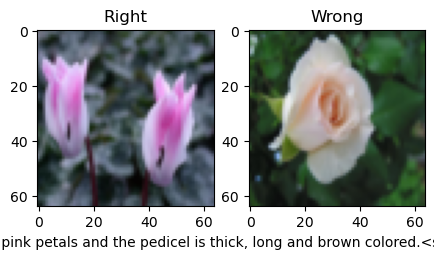

In [70]:
#  right and wrongs to be sure its working
id = np.random.randint(len(train_dataset))
right, wrong = train_dataset[id]
_, axs = plt.subplots(1, 2, figsize=(5, 5))
simulation(*right, train_dataset.tokenizer, axs[0], "Right")
simulation(*wrong, ax = axs[1], title = "Wrong")
plt.show()

In [71]:
#using previous checkpoint, this was the only way to get better result to train save the checkpoints and again train
if os.path.exists(os.path.join(output_path, '/kaggle/input/params/modelparams.pth')):
    checkpoint = torch.load(os.path.join(output_path,'modelparams.pth'), map_location=device)
    torch.save(checkpoint, "modelparams.pth")
else:
    checkpoint = {}
# train and valid samplers
train_ind = checkpoint.get('train_ind', None)
valid_ind = checkpoint.get('valid_ind', None)
if train_ind is None or valid_ind is None:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    splitter = sss.split(train_dataset, np.array([len(x["text"]["in_id"])%10 for x in train_dataset.data]))
    train_ind, valid_ind = next(splitter)
train_samp = SubsetRandomSampler(train_ind)
valid_samp = SubsetRandomSampler(valid_ind)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_samp, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_samp, collate_fn=train_dataset.collate_fn, drop_last=True)

In [72]:
import torch
#cuda and gpu setting
if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")
models = {
    "text_encoder": Encoder_text().to(device),
    "generator": Generator().to(device),
    "discriminator": Discriminator().to(device)
}
optimizers = {}
schedulers = {}
criterion = nn.CrossEntropyLoss()
learning_rates = {"text_encoder": 1e-4, "generator": 5e-4, "discriminator": 1e-4}
for key in models:
    if key == "text_encoder": continue
    models[key].load_state_dict(checkpoint.get("models", {}).get(key, models[key].state_dict()))
    # Prepare linear warmup and decay optimizer and schedulers 
    optimizers[key] = torch.optim.Adam(models[key].parameters(), lr=learning_rates[key], weight_decay=1e-6)
    optimizers[key].load_state_dict(checkpoint.get("optimizers", {}).get(key, optimizers[key].state_dict()))
    schedulers[key] = torch.optim.lr_scheduler.StepLR(optimizers[key], step_size=50, gamma=0.1, last_epoch=-1)
    schedulers[key].load_state_dict(checkpoint.get("schedulers", {}).get(key, schedulers[key].state_dict()))

CUDA is available.
GPU device name: Tesla P100-PCIE-16GB


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [77]:
# validation run
def validation():
    dis_loss_t, gen_loss_t = 0, 0
    dis_acc_t, gen_acc_t = 0, 0
    temp = "Dis Loss: {:.4f}, Dis ACC: {:.4f}, Gen Loss: {:.4f}, Gen ACC: {:.4f}"
    for key in models:
        models[key].eval()
    loader = tqdm(valid_loader, desc = f"Validating")
    for id, ((right_images, right_texts), (wrong_images, wrong_texts)) in enumerate(loader, start=1):
        with torch.no_grad():
            enc_r_texts = models["text_encoder"](**right_texts).detach()
            enc_w_texts = models["text_encoder"](**wrong_texts).detach()
            #noise and fake
            noise = torch.randn((len(right_images), 100, 1, 1),device = device)
            ones = torch.ones((len(right_images)), dtype=torch.long, device=device)
            zeros = torch.zeros((len(right_images)), dtype=torch.long, device=device)
            fake_images = models["generator"](noise, enc_r_texts)
            # dis for wrong and fake
            dis_r_logits = models["discriminator"](right_images, enc_r_texts)
            dis_w_t_logits =  models["discriminator"](right_images, enc_w_texts)
            dis_w_i_logits =  models["discriminator"](wrong_images, enc_r_texts)
            dis_f_logits = models["discriminator"](fake_images.detach(), enc_r_texts)
            dis_r_loss = criterion(dis_r_logits, ones)
            dis_w_t_loss = criterion(dis_w_t_logits, zeros)
            dis_w_i_loss = criterion(dis_w_i_logits, zeros)
            dis_f_loss = criterion(dis_f_logits, zeros)
            dis_loss = dis_r_loss + 0.25*dis_w_t_loss + 0.25*dis_w_i_loss + 0.5*dis_f_loss
            dis_f_logits = models["discriminator"](fake_images, enc_r_texts)
            gen_loss = criterion(dis_f_logits, ones)
        dis_acc, gen_ACC = torch.tensor(0), torch.tensor(0)
        dis_loss_t += dis_loss.item(); gen_loss_t += gen_loss.item()
        dis_acc_t += dis_acc.item(); gen_ACC += gen_ACC.item()
        loader.set_postfix_str(temp.format(dis_loss, dis_acc, gen_loss, gen_ACC))
        loader.update()
        # resetting variables
        del right_images; del right_texts; del wrong_images; del wrong_texts
        del enc_r_texts; del enc_w_texts; del noise; del fake_images
        del ones; del zeros; del dis_r_logits; del dis_w_t_logits
        del dis_w_i_logits; del dis_f_logits; del dis_r_loss
        del dis_w_t_loss; del dis_w_i_loss; del dis_f_loss
        del dis_loss; del gen_loss; del dis_acc; del gen_ACC
        torch.cuda.empty_cache()
    temp = temp.format(dis_loss_t/id, dis_acc_t/id, gen_loss_t/id, gen_acc_t/id)
    loader.write(f"Validated | {temp}")
    return dis_loss_t/id, dis_acc_t/id, gen_loss_t/id, gen_acc_t/id

In [78]:
def train():
    dis_loss_t, gen_loss_t = 0, 0
    dis_acc_t, gen_acc_t = 0, 0
    temp = "Dis Loss: {:.4f}, Dis ACC: {:.4f}, Gen Loss: {:.4f}, Gen ACC: {:.4f}"
    for key in models:
        models[key].train()
    loader = tqdm(train_loader, desc = f"Training")
    for id, ((right_images, right_texts), (wrong_images, wrong_texts)) in enumerate(loader, start=1):
        enc_r_texts = models["text_encoder"](**right_texts).detach()
        enc_w_texts = models["text_encoder"](**wrong_texts).detach()
        #noise and fake
        noise = torch.randn((len(right_images), 100, 1, 1), device=device)
        ones = torch.ones((len(right_images)), dtype=torch.long, device=device)
        zeros = torch.zeros((len(right_images)), dtype=torch.long, device=device)
        fake_images = models["generator"](noise, enc_r_texts)
        #dis for wrong and fake
        dis_r_logits = models["discriminator"](right_images, enc_r_texts)
        dis_w_t_logits = models["discriminator"](right_images, enc_w_texts)
        dis_w_i_logits = models["discriminator"](wrong_images, enc_r_texts)
        dis_f_logits = models["discriminator"](fake_images.detach(), enc_r_texts)
        dis_r_loss = criterion(dis_r_logits, ones)
        dis_w_t_loss = criterion(dis_w_t_logits, zeros)
        dis_w_i_loss = criterion(dis_w_i_logits, zeros)
        dis_f_loss = criterion(dis_f_logits, zeros)
        dis_loss = dis_r_loss + 0.25*dis_w_t_loss + 0.25*dis_w_i_loss + 0.5*dis_f_loss
        #opt
        optimizers["discriminator"].zero_grad()
        dis_loss.backward()
        optimizers["discriminator"].step()
        dis_f_logits = models["discriminator"](fake_images, enc_r_texts)
        gen_loss = criterion(dis_f_logits, ones)
        optimizers["generator"].zero_grad()
        gen_loss.backward()
        optimizers["generator"].step()
        dis_acc, gen_ACC = torch.tensor(0), torch.tensor(0)
        dis_loss_t += dis_loss.item(); gen_loss_t += gen_loss.item()
        dis_acc_t += dis_acc.item(); gen_acc_t += gen_ACC.item()
        loader.set_postfix_str(temp.format(dis_loss, dis_acc, gen_loss, gen_ACC))
        loader.update()
        # resetting variables
        del right_images; del right_texts; del wrong_images; del wrong_texts
        del enc_r_texts; del enc_w_texts; del noise; del fake_images
        del ones; del zeros; del dis_r_logits; del dis_w_t_logits
        del dis_w_i_logits; del dis_f_logits; del dis_r_loss
        del dis_w_t_loss; del dis_w_i_loss; del dis_f_loss
        del dis_loss; del gen_loss; del dis_acc; del gen_ACC
        torch.cuda.empty_cache()
    temp = temp.format(dis_loss_t/id, dis_acc_t/id, gen_loss_t/id, gen_acc_t/id)
    loader.write(f"Trained | {temp}")
    for key in schedulers:
        schedulers[key].step()
    return dis_loss_t/id, dis_acc_t/id, gen_loss_t/id, gen_acc_t/id

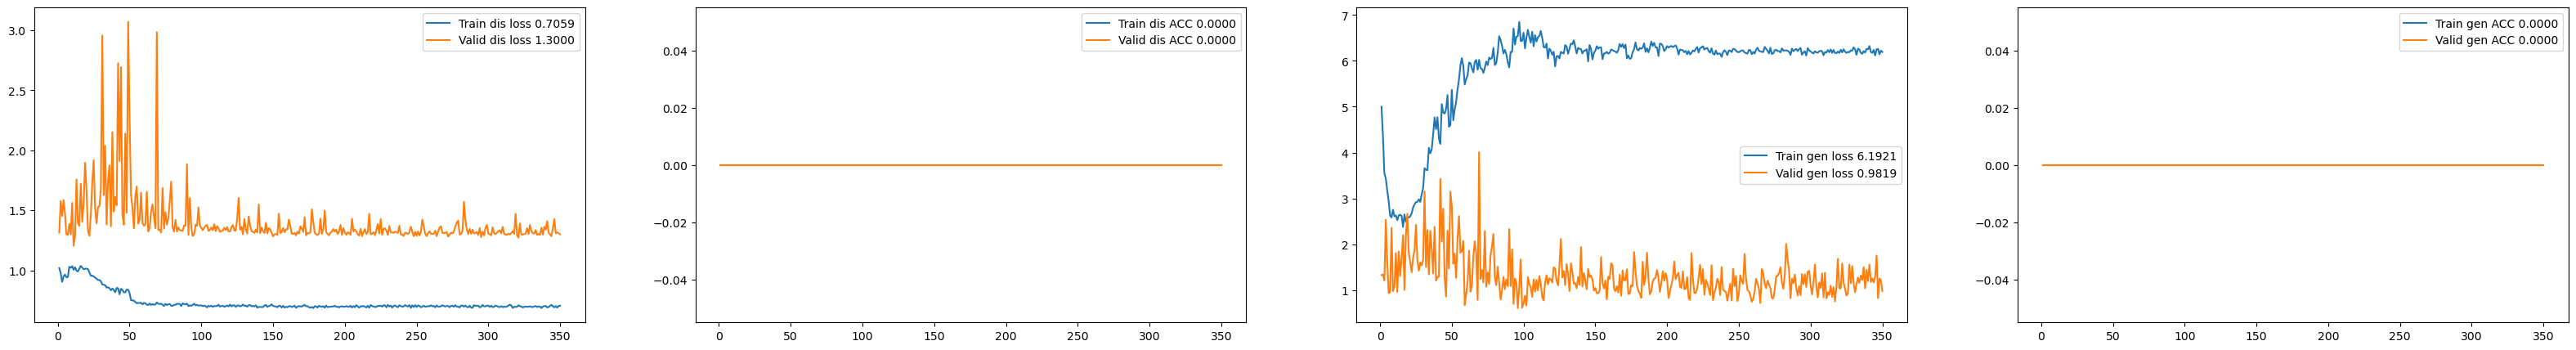

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Output()

HTML(value='<b>Training statred: True</b>')

TRAINING IS FINISHED!


In [79]:
train_data = checkpoint.get('train_data', np.empty((0, 4)))
valid_data = checkpoint.get('valid_data', np.empty((0, 4)))
epoch_data = checkpoint.get('epoch_data', [])
# del checkpoint
def plot_training_data(ax, epoch_data, train_data, valid_data):
    ax[0].clear(); ax[1].clear(); ax[2].clear(); ax[3].clear()
    x_train = epoch_data[:train_data.shape[0]]
    x_valid = epoch_data[:valid_data.shape[0]]
    ax[0].plot(x_train, train_data[:, 0], label=f"Train dis loss {train_data[-1, 0]:.4f}")
    ax[0].plot(x_valid, valid_data[:, 0], label=f"Valid dis loss {valid_data[-1, 0]:.4f}")
    ax[1].plot(x_train, train_data[:, 1], label=f"Train dis ACC {train_data[-1, 1]:.4f}")
    ax[1].plot(x_valid, valid_data[:, 1], label=f"Valid dis ACC {valid_data[-1, 1]:.4f}")
    ax[2].plot(x_train, train_data[:, 2], label=f"Train gen loss {train_data[-1, 2]:.4f}")
    ax[2].plot(x_valid, valid_data[:, 2], label=f"Valid gen loss {valid_data[-1, 2]:.4f}")
    ax[3].plot(x_train, train_data[:, 3], label=f"Train gen ACC {train_data[-1, 3]:.4f}")
    ax[3].plot(x_valid, valid_data[:, 3], label=f"Valid gen ACC {valid_data[-1, 3]:.4f}")
    ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend()
if epoch_data:
    fig, ax = plt.subplots(1, 4, figsize=(10*4, 5))
    plot_training_data(ax, epoch_data, train_data, valid_data)
    plt.show()
# running the trainer
loader = tqdm(range(len(epoch_data), len(epoch_data) + num_epoch * training), desc = "Epoch")
board = ipywidgets.Output()
if training: display.display(board)
graph = display.display(ipywidgets.widgets.HTML(f"<b>Training statred: {bool(training)}</b>"), display_id = True)
for i in loader:
    with board:
        # realtime plots
        epoch_data.append(i+1)
        fig, ax = plt.subplots(1, 4, figsize=(10*4, 5))
        plt.close(fig)
        train_data = np.append(train_data, [train()], axis = 0)
        valid_data = np.append(valid_data, [validation()], axis = 0)
        plot_training_data(ax, epoch_data, train_data, valid_data)
        graph.update(fig)
        display.clear_output()
        graph = display.display(fig, display_id = True)
    # Saving models
    params = {
        'models': dict([(key, models[key].state_dict()) for key in models]),
        'optimizers': dict([(key, optimizers[key].state_dict()) for key in optimizers]),
        'schedulers': dict([(key, schedulers[key].state_dict()) for key in schedulers]),
        'train_ind': train_ind,
        'valid_ind': valid_ind,
        'train_data': train_data,
        'valid_data': valid_data,
        'epoch_data': epoch_data
    }
    torch.save(params, "modelparams.pth")
loader.write("TRAINING IS FINISHED!")

In [99]:
print(train_data[-1, 3])

0.0


{'in_id': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 52, 3939, 1170, 6090, 4566, 212, 68, 7544, 51, 24, 3493, 17, 2742, 23, 5356, 9, 4, 3], 'token_id': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'atten_m': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
this bright red orange petaled flower has a yellow pistil.<sep><cls>


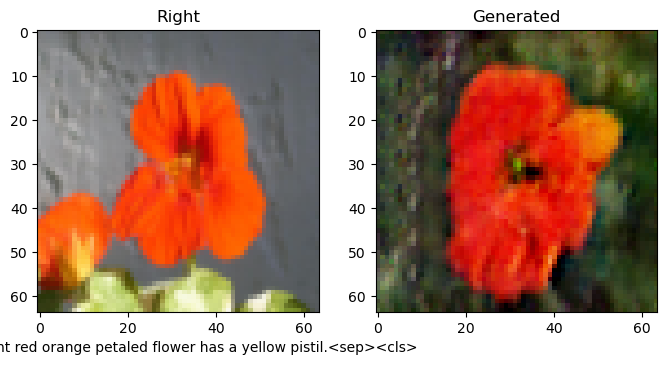

In [210]:
id = np.random.randint(len(train_dataset))
(image, text), _ = train_dataset[id]
params = {}
print(text)
for key in text:
    params[key] = torch.tensor(text[key], device=device)[None]
for key in models:
    models[key].eval()
enc_text = models["text_encoder"](**params)
noise = torch.randn((1, 100, 1, 1), device=device)
gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()
_, axs = plt.subplots(1, 2, figsize=(8, 8))

simulation(image, text, train_dataset.tokenizer, axs[0], "Right")
simulation(gen_image, text, None, axs[1], "Generated")
plt.show()

 this flower has white petals and a yellow stamen


this flower has white petals and a yellow stamen<sep><cls>


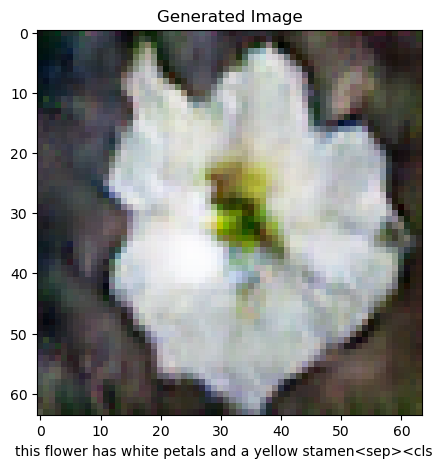

In [183]:
params = {}
txt=input()
text = np.array(txt).item().strip()
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
in_id = tokenizer.encode(text)
token_id = [0] * (len(in_id) - 1) + [1]
atten_m = [1] * len(token_id)
text = {
    "in_id": in_id,
    "token_id": token_id,
    "atten_m": atten_m
}
for key in models:
    models[key].eval()
for key in text:
#     print(key)
    params[key] = torch.tensor(text[key], device=device)[None]
enc_text = models["text_encoder"](**params)
noise = torch.randn((1, 100, 1, 1), device=device)
gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()

_, ax = plt.subplots(1, 1, figsize=(5, 5))
simulation(gen_image, text, train_dataset.tokenizer, ax, title = "Generated Image")
plt.show()

In [156]:
!pip install kaggle